# Canny Detection

Denny Alvito Ginting
2440101300

This code is inspired from:
https://www.youtube.com/watch?v=H3piMlA6O9Q&ab_channel=KodepyCoding

## Importing Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

## Loading Image

In [ ]:
def visualize_img(img, title):
  plt.figure(figsize=(12,6))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(title)
  plt.show()

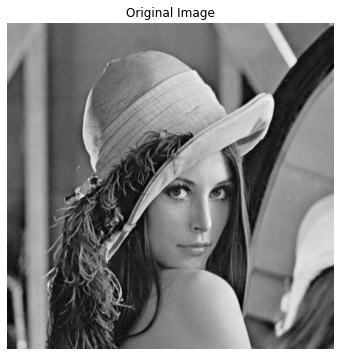

In [ ]:
img = cv2.imread('/content/canny-pic.jpg')

# Grayscaling
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Visualizing
visualize_img(img, 'Original Image')

## Smoothing Image
To smoothing the image, we will use `Gaussian Filter` to reduce the noise from image

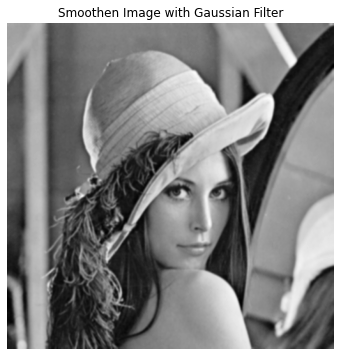

In [ ]:
# Transform to float to enhance the detail of each pixel
img = img.astype(np.float64)

# Gaussian Filtering
img_blur = cv2.GaussianBlur(img, (5,5), 0)

# Visualizing
visualize_img(img_blur, 'Smoothen Image with Gaussian Filter')

## Computing Gradient with Sobel Kernel
In this step, we will take the gradient (with its orientation) using `Sobel Kernel`

In [ ]:
def sobel(img):
  
  # Filter to take Gradient X
  Gx = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]], np.float32)

  # Filter to take Gradient Y
  Gy = np.array([[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]], np.float32)
  
  # Convolve with X orientiation
  Sx = ndimage.filters.convolve(img, Gx)

  # Convolve with Y orientiation
  Sy = ndimage.filters.convolve(img, Gy)

  # Computing Gradient
  G = np.sqrt(Sx**2 + Sy**2)
  G = G / G.max()*255

  # Taking direction (angle)
  theta = np.arctan2(Sy, Sx)

  return G, theta

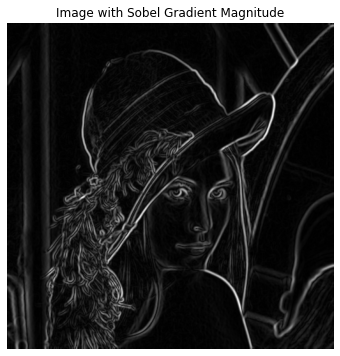

In [ ]:
img_sobel, direction = sobel(img_blur)
visualize_img(img_sobel, 'Image with Sobel Gradient Magnitude')

## Extracting Edge Point with Non-Maximum Suppression

In [ ]:
def non_max_suppression(img, direction):
  M, N = img.shape
  z = np.zeros((M, N), dtype=np.int32)
  angle = direction * 180./np.pi
  angle[angle < 0] += 180

  # Iterating to find neighbors with the same direction
  for i in range(1, M-1):
    for j in range(1, N-1):

      # Initializing the intensity
      q = 255
      r = 255

      # Angle 0
      if (angle[i, j] <= 22.5) or (157.5 <= angle[i, j] <= 180):
        q = img[i, j+1]
        r = img[i, j-1]
      
      # Angle 45
      if (22.5 <= angle[i, j] <= 67.5):
        q = img[i+1, j-1]
        r = img[i-1, j+1]
      
      # Angle 90
      if (67.5 <= angle[i, j] <= 112.5):
        q = img[i+1, j]
        r = img[i-1, j]

      # Angle 134
      if (112.5 <= angle[i, j] <= 157.5):
        q = img[i-1, j-1]
        r = img[i+1, j+1]
      
      """
      if the current edge pixel has higher 
      or same intensity of gradient with its neighbors, 
      then the pixel value will be the same with its neighbors.

      Else it will be zeroed (suppressed)
      """

      if (img[i, j] >= q) and (img[i, j] >= r):
        z[i, j] = img[i, j]
      else:
        z[i, j] = 0 
  
  return z

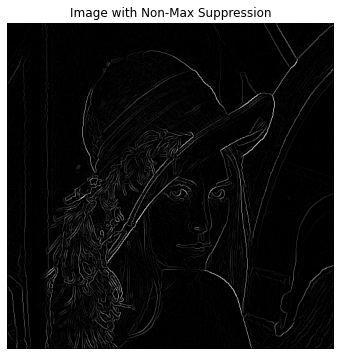

In [ ]:
img_non_max = non_max_suppression(img_sobel, direction)
visualize_img(img_non_max, 'Image with Non-Max Suppression')

## Double Thresholding (First Step of Hysteresis Thresholding)

In [ ]:
def double_threshold(img):

  # Would be good with scale of 3:1
  high_threshold = 60
  low_threshold = 20

  M, N = img.shape
  new_image = np.zeros((M, N), dtype=np.int32)

  # Defining the weak and strong pixel
  weak = np.int32(150)
  strong = np.int32(255)

  """ Filter the pixel with thresholding

  a.	If the intensity of pixel is higher or the same with high threshold, 
      then it will be kept (and identified as edge)

  b.	If the intensity of pixel is lower than high threshold 
      but higher than or the same with low threshold, 
      then it will be kept (but can’t be identified as edge)

  c.	If the intensity of pixel is lower than low threshold 
      then it will be removed (not detected as edge)

  """

  strong_Y, strong_X = np.where(img >= high_threshold)
  weak_Y, weak_X = np.where((img <= high_threshold) & (img >= low_threshold))
  zeros_Y, zeros_X = np.where(img < low_threshold)

  new_image[strong_Y, strong_X] = strong
  new_image[weak_Y, weak_X] = weak

  return new_image

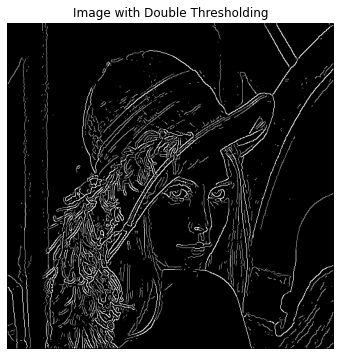

In [ ]:
img_threshold = double_threshold(img_non_max)
visualize_img(img_threshold, 'Image with Double Thresholding')

> As we can see, the first step of `Hysteresis Thresholding` which is `Double Thresholding` produce an edge with still have several visible `weak edge`, the following step is to remove this weak edges

## Hysteresis (Next step of Hysteresis Thresholding)

In [ ]:
def hysteresis(img):
  """
  Hysteresis:
  a.	If the surrounding neighbors of the current weak intensity 
      of pixel has a strong pixel intensity, then the current pixel
      will be classified as edge.

  b.	If the surrounding neighbors of the current weak intensity
      of pixel has no strong pixel intensity, then the current pixel
      will NOT be classified as edge.

  """

  M, N = img.shape
  strong = 255
  weak = 150

  # Iterating through the current weak edges' neighbors
  for i in range(1, (M-1)):
    for j in range(1, (N-1)):
      if img[i, j] == weak:
        if ((img[i-1, j-1] == strong) or (img[i-1,j] == strong) or 
           (img[i-1, j+1] == strong) or (img[i, j-1] == strong) or
           (img[i, j+1] == strong) or (img[i+1, j-1] == strong) or
           (img[i+1, j] == strong) or (img[i+1, j+1] == strong)):
          img[i,j] = strong
        else:
          img[i,j] = 0
  
  return img

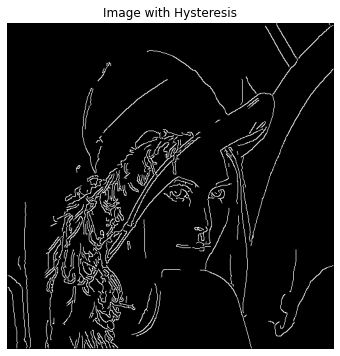

In [ ]:
img_hysteresis = hysteresis(img_threshold)
visualize_img(img_hysteresis, 'Image with Hysteresis')

> As we can see, the edges and background can be easily differentiated, which means the `Edge Detection` using `Canny Detection` is done completely.

## Visualizing Clearly The Images

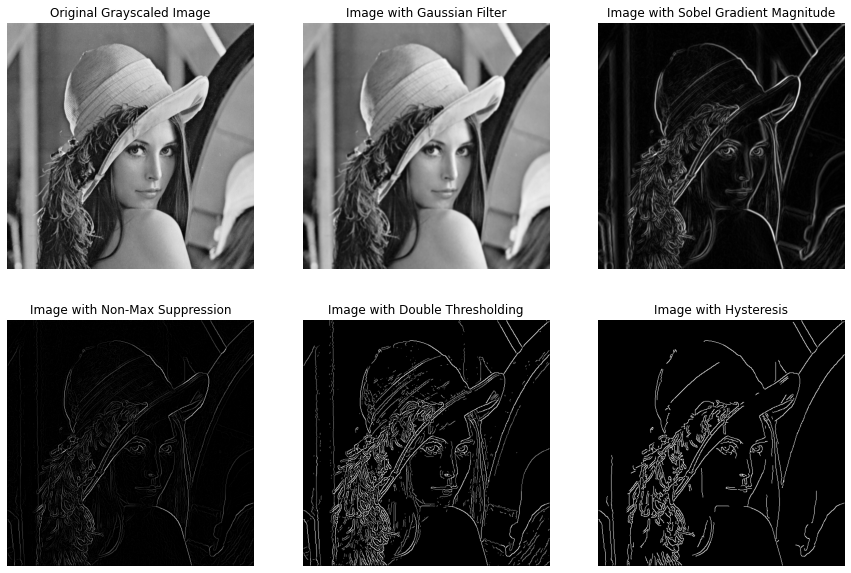

In [ ]:
plt.figure(figsize=(15,10))

img_list = [img, img_blur, img_sobel,
            img_non_max, img_threshold, img_hysteresis]
img_title = [
    'Original Grayscaled Image',
    'Image with Gaussian Filter',
    'Image with Sobel Gradient Magnitude',
    'Image with Non-Max Suppression',
    'Image with Double Thresholding',
    'Image with Hysteresis'
]

for i, (curr_img, curr_title) in enumerate(zip(img_list, img_title)):
  plt.subplot(2,3,(i+1))
  plt.imshow(curr_img, cmap='gray')
  plt.title(curr_title)
  plt.axis('off')

plt.show()